In [1]:
from pathlib import Path

from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from fastsolv._module import _ALL_MODELS, _DESCRIPTOR_COLUMNS
from fastprop.data import standard_scale

# for compatibility with shap
for model in _ALL_MODELS:
    model.fnn.pop(0)
    model.fnn.pop(0)
# we remove the concatenation module, which we instead do manually here
# and the clamp module which is unsupported by SHAP

/home/jackson/miniconda3/envs/fastsolv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_df = pd.read_csv(Path("../data/vermeire/solprop_fastprop_nonaq.csv"))

In [3]:
# need between 100 and 1000 samples to get a good estimate of the SHAP values
test_df = test_df.sample(n=2000, random_state=0)

In [4]:
inputs = torch.tensor(test_df[_DESCRIPTOR_COLUMNS + ["temperature"]].to_numpy(), dtype=torch.float32)
targets = torch.tensor(test_df["logS"].to_numpy(), dtype=torch.float32)
# we will use half of the data for 'integrating', and the other half for getting shap values
halfway_idx = inputs.shape[0] // 2

In [5]:
# shap terminology explanation:
# background: 100 to 1000 random samples from the training data
# X: 100+ other samples
# run shap on each of these models, then average the results
per_model_shap = []
for model in tqdm(_ALL_MODELS, desc="Calculating SHAP values for each model"):
    # now scale and send the data to whatever device lightning put the model on
    X = inputs.to(model.device)
    solute_features, solvent_features, temperature = X[:, 0:1613], X[:, 1613:1613+1613], X[:, 1613+1613]  # batch 1 is solubility
    solute_features = standard_scale(solute_features, model.solute_means, model.solute_vars)
    solvent_features = standard_scale(solvent_features, model.solvent_means, model.solvent_vars)
    temperature = standard_scale(temperature, model.temperature_means, model.temperature_vars)
    scaled_X = torch.cat((solute_features, solvent_features, temperature[:, None]), dim=1)
    scaled_X.clamp_(min=-3.0, max=3.0)
    e = shap.DeepExplainer(model, scaled_X[:halfway_idx])
    model_shap_values = e.shap_values(scaled_X[halfway_idx:])
    # returns a list for multi-target problems, cast for uniformity
    if not isinstance(model_shap_values, list):
        model_shap_values = [model_shap_values]
    per_model_shap.append(model_shap_values)
all_shap_values = np.mean(np.array(per_model_shap), axis=0)

Calculating SHAP values for each model: 100%|██████████| 4/4 [03:56<00:00, 59.25s/it]


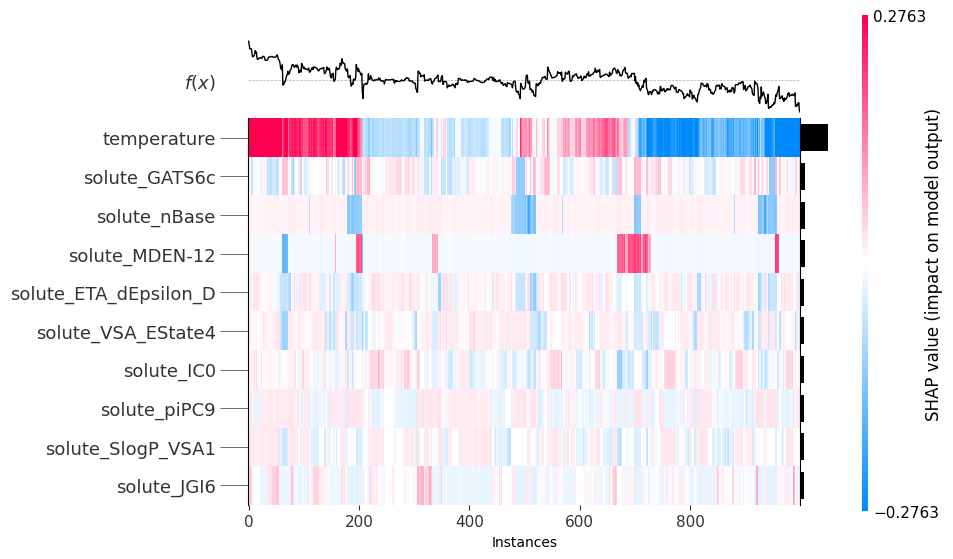

In [6]:
# for each target, create a plot of the most important features
importance_threshold = 0.70
for i, target_name in enumerate(("logS", )):
    shap_values = all_shap_values[i].squeeze()
    # include features until the shap value is half the highest, aka half as important
    avg_shaps = np.mean(np.abs(shap_values), axis=0)
    avg_shaps, names, keep_idxs = zip(*sorted(zip(avg_shaps, _DESCRIPTOR_COLUMNS + ["temperature"], list(range(len(avg_shaps)))), reverse=True))
    include_idx = 10
    # for val in avg_shaps[1:]:
    #     if val > avg_shaps[0] * importance_threshold:
    #         include_idx += 1
    #     else:
    #         break
    explanation = shap.Explanation(values=shap_values[:, keep_idxs[:include_idx]], feature_names=names[0:include_idx])
    plt.cla()
    _ = shap.plots.beeswarm(explanation, max_display=include_idx + 1, color_bar=False, color="shap_red", show=False)
    plt.savefig("shap_solprop_beeswarm.svg", pad_inches=0.5, bbox_inches="tight")
    plt.cla()
    _ = shap.plots.bar(explanation, max_display=include_idx + 1, show=False)
    plt.savefig("shap_solprop_bar.svg", pad_inches=0.5, bbox_inches="tight")
    plt.cla()
    _ = shap.plots.heatmap(explanation, max_display=include_idx + 1, show=False)
    plt.savefig("shap_solprop_heatmap.svg", pad_inches=0.5, bbox_inches="tight")

In [11]:
np.mean(np.abs(explanation.values), axis=0)

array([0.17366989, 0.03067012, 0.02852711, 0.02781993, 0.02663113,
       0.02576038, 0.02416371, 0.02296507, 0.0215939 , 0.02110975])

In [12]:
test_df = pd.concat(
    (pd.read_csv(Path("../data/boobier/leeds_acetone_fastprop.csv")),
     pd.read_csv(Path("../data/boobier/leeds_benzene_fastprop.csv")),
     pd.read_csv(Path("../data/boobier/leeds_ethanol_fastprop.csv")),
    ))
# no need to downsample - already <2000 - just shuffle
test_df = test_df.sample(frac=1.0, random_state=21)

In [13]:
inputs = torch.tensor(test_df[_DESCRIPTOR_COLUMNS + ["temperature"]].to_numpy(), dtype=torch.float32)
targets = torch.tensor(test_df["logS"].to_numpy(), dtype=torch.float32)
# we will use half of the data for 'integrating', and the other half for getting shap values
halfway_idx = inputs.shape[0] // 2

In [14]:
# shap terminology explanation:
# background: 100 to 1000 random samples from the training data
# X: 100+ other samples
# run shap on each of these models, then average the results
per_model_shap = []
for model in tqdm(_ALL_MODELS, desc="Calculating SHAP values for each model"):
    # now scale and send the data to whatever device lightning put the model on
    X = inputs.to(model.device)
    solute_features, solvent_features, temperature = X[:, 0:1613], X[:, 1613:1613+1613], X[:, 1613+1613]  # batch 1 is solubility
    solute_features = standard_scale(solute_features, model.solute_means, model.solute_vars)
    solvent_features = standard_scale(solvent_features, model.solvent_means, model.solvent_vars)
    temperature = standard_scale(temperature, model.temperature_means, model.temperature_vars)
    scaled_X = torch.cat((solute_features, solvent_features, temperature[:, None]), dim=1)
    scaled_X.clamp_(min=-3.0, max=3.0)
    e = shap.DeepExplainer(model, scaled_X[:halfway_idx])
    model_shap_values = e.shap_values(scaled_X[halfway_idx:])
    # returns a list for multi-target problems, cast for uniformity
    if not isinstance(model_shap_values, list):
        model_shap_values = [model_shap_values]
    per_model_shap.append(model_shap_values)
all_shap_values = np.mean(np.array(per_model_shap), axis=0)

Calculating SHAP values for each model: 100%|██████████| 4/4 [01:38<00:00, 24.54s/it]


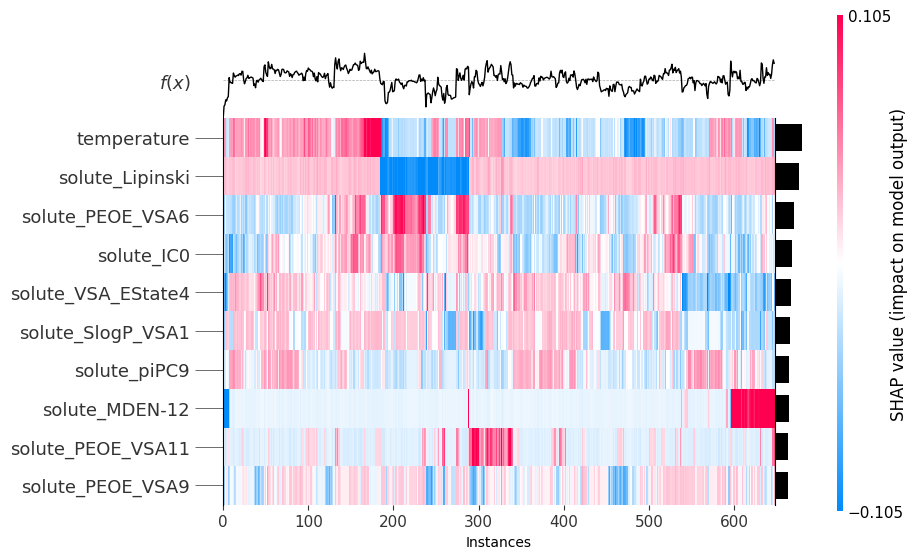

In [15]:
# for each target, create a plot of the most important features
importance_threshold = 0.70
for i, target_name in enumerate(("logS", )):
    shap_values = all_shap_values[i].squeeze()
    # include features until the shap value is half the highest, aka half as important
    avg_shaps = np.mean(np.abs(shap_values), axis=0)
    avg_shaps, names, keep_idxs = zip(*sorted(zip(avg_shaps, _DESCRIPTOR_COLUMNS + ["temperature"], list(range(len(avg_shaps)))), reverse=True))
    include_idx = 10
    # for val in avg_shaps[1:]:
    #     if val > avg_shaps[0] * importance_threshold:
    #         include_idx += 1
    #     else:
    #         break
    explanation = shap.Explanation(values=shap_values[:, keep_idxs[:include_idx]], feature_names=names[0:include_idx])
    plt.cla()
    _ = shap.plots.beeswarm(explanation, max_display=include_idx + 1, color_bar=False, color="shap_red", show=False)
    plt.savefig("shap_leeds_beeswarm.svg", pad_inches=0.5, bbox_inches="tight")
    plt.cla()
    _ = shap.plots.bar(explanation, max_display=include_idx + 1, show=False)
    plt.savefig("shap_leeds_bar.svg", pad_inches=0.5, bbox_inches="tight")
    plt.cla()
    _ = shap.plots.heatmap(explanation, max_display=include_idx + 1, show=False)
    plt.savefig("shap_leeds_heatmap.svg", pad_inches=0.5, bbox_inches="tight")

In [16]:
np.mean(np.abs(explanation.values), axis=0)

array([0.04243899, 0.03794437, 0.02975977, 0.02663366, 0.02528701,
       0.02392962, 0.02178172, 0.02173062, 0.02053776, 0.01998049])